In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/nlp_putin'
os.chdir(folder_path)

!ls
!unzip -o putin_complete_cleaned.json.zip

__MACOSX  putin_complete_cleaned.json  putin_complete_cleaned.json.zip
Archive:  putin_complete_cleaned.json.zip
  inflating: putin_complete_cleaned.json  
  inflating: __MACOSX/._putin_complete_cleaned.json  


In [ ]:
import json
import pandas as pd

with open("putin_complete_cleaned.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

first_row = df.iloc[0]

for k, v in first_row.items():
    print(f"{k}: {v}")

date: 946598460000
persons: []
transcript_unfiltered: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV, just as you probably did, to listen to the address by President Boris Yeltsin. But things took a different turn. On December 31, 1999, Russia’s first president decided to resign. He has asked me to address the Russian people today. The powers of the head of state have been turned over to me today. The presidential election will be held in three months. I assure you that there will be no vacuum of power, not for a minute. I promise you that any attempts to act contrary to the Russian law and constitution will be cut short. The state will stand firm to protect the freedom of speech, the freedom of conscience, the freedom of the mass media, ownership rights, these fundamental elements of a civilised society. The Armed Forces, the Federal Frontier Service, and law-enforcement agencies are working in the usual regime. The state continues to uphold the safety

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

from transformers import pipeline
import matplotlib.pyplot as plt

rows = []

for _, row in df.iterrows():
    year = row["year"]
    for sent in row["sentences"]:
        rows.append({
            "year": year,
            "sentence": sent
        })

prop_df = pd.DataFrame(rows)
prop_df.head()

,year,sentence
0,1999,"Dear friends, On New Year’s Eve, my family and..."
1,1999,But things took a different turn.
2,1999,"On December 31, 1999, Russia’s first president..."
3,1999,He has asked me to address the Russian people ...
4,1999,The powers of the head of state have been turn...


In [ ]:
len(prop_df)

389970

In [ ]:
prop_df["word_count"] = prop_df["sentence"].apply(lambda x: len(x.split()))

prop_df = prop_df[prop_df["word_count"] >= 10].reset_index(drop=True)

prop_df = prop_df.drop(columns=["word_count"])

prop_df.head()

,year,sentence
0,1999,"Dear friends, On New Year’s Eve, my family and..."
1,1999,"On December 31, 1999, Russia’s first president..."
2,1999,He has asked me to address the Russian people ...
3,1999,The powers of the head of state have been turn...
4,1999,I assure you that there will be no vacuum of p...


In [ ]:
len(prop_df)

299593

In [ ]:
import torch
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

device = 0 if torch.cuda.is_available() else -1

binary_detector = pipeline(
    "text-classification",
    model="synapti/nci-binary-detector-v2",
    truncation=True,
    max_length=512,
    device=device
)

batch_size = 128
output_file = "propaganda_results.csv"

first_batch = True

for i in tqdm(range(0, len(prop_df), batch_size), desc="Propaganda prediction"):
    batch_sentences = prop_df["sentence"].iloc[i:i+batch_size].tolist()
    batch_years = prop_df["year"].iloc[i:i+batch_size].tolist()

    batch_results = binary_detector(batch_sentences)

    batch_df = pd.DataFrame({
        "year": batch_years,
        "sentence": batch_sentences,
        "prop_label": [r["label"] for r in batch_results],
        "prop_score": [r["score"] for r in batch_results],
    })
    batch_df["is_propaganda"] = batch_df["prop_label"] == "has_propaganda"

    batch_df.to_csv(output_file, mode="w" if first_batch else "a", index=False, header=first_batch)
    first_batch = False

Device set to use cuda:0
Propaganda prediction: 100%|██████████| 2341/2341 [2:27:54<00:00,  3.79s/it]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/nlp_putin/propaganda_results.csv")

In [ ]:
total_sentences = len(df)
propaganda_sentences = df["is_propaganda"].sum()

ratio = propaganda_sentences / total_sentences

print(f"Propaganda sentences: {propaganda_sentences}")
print(f"All sentences: {total_sentences}")
print(f"Ratio: {ratio:.2%}")

Propaganda sentences: 162286
All sentences: 299593
Ratio: 54.17%


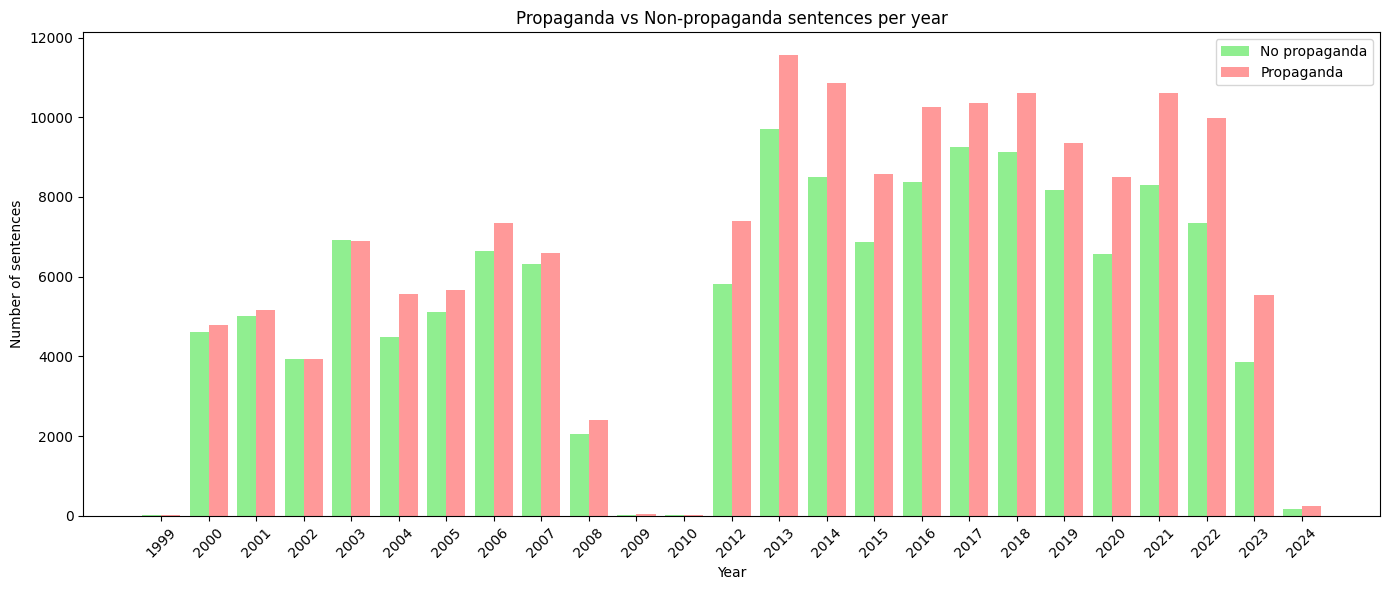

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

year_counts = (
    df
    .groupby(["year", "is_propaganda"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: "no_propaganda", True: "propaganda"})
)

x = np.arange(len(year_counts.index))
width = 0.4

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    year_counts["no_propaganda"],
    width=width,
    color="#90ee90",
    label="No propaganda"
)

plt.bar(
    x + width/2,
    year_counts["propaganda"],
    width=width,
    color="#ff9999",
    label="Propaganda"
)

plt.xticks(x, year_counts.index, rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of sentences")
plt.title("Propaganda vs Non-propaganda sentences per year")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,year,sentence,prop_label,prop_score,is_propaganda
0,1999,"Dear friends, On New Year’s Eve, my family and...",no_propaganda,0.722130,False
1,1999,"On December 31, 1999, Russia’s first president...",no_propaganda,0.985961,False
2,1999,He has asked me to address the Russian people ...,no_propaganda,0.911510,False
3,1999,The powers of the head of state have been turn...,no_propaganda,0.944206,False
4,1999,I assure you that there will be no vacuum of p...,has_propaganda,0.782705,True
